# Performing measurements using QCoDeS parameters and DataSet

This notebook shows some ways of performing different measurements using 
QCoDeS parameters and the [DataSet](DataSet-class-walkthrough.ipynb) via a powerful ``Measurement`` context manager. Here, it is assumed that the reader has some degree of familiarity with fundamental objects and methods of QCoDeS.

Users should note that, here, within the context of experiments, one cannot nest multiple managers to perform related or independent measurements. This is a particular consequence of how data is stored and managed.

Now, let us start with necessary imports:

In [1]:
%matplotlib inline
import numpy.random as rd
import matplotlib.pyplot as plt
from functools import partial
import numpy as np

from time import sleep, monotonic

import qcodes as qc
from qcodes import Station, load_or_create_experiment, \
    initialise_database, Measurement, load_by_run_spec, load_by_guid
from qcodes.tests.instrument_mocks import DummyInstrument
from qcodes.dataset.plotting import plot_dataset

qc.logger.start_all_logging()

Logging hadn't been started.
Activating auto-logging. Current session state plus future input saved.
Filename       : /home/vsts/.qcodes/logs/command_history.log
Mode           : append
Output logging : True
Raw input log  : False
Timestamping   : True
State          : active


Qcodes Logfile : /home/vsts/.qcodes/logs/200320-20452-qcodes.log
Activating auto-logging. Current session state plus future input saved.
Filename       : /home/vsts/.qcodes/logs/command_history.log
Mode           : append
Output logging : True
Raw input log  : False
Timestamping   : True
State          : active


Qcodes Logfile : /home/vsts/.qcodes/logs/200320-20452-qcodes.log


In what follows, we shall define some utility functions as well as declare our dummy instruments. We, then, add these instruments to a ``Station`` object. 

In [2]:
# a generator to simulate a physical signal, in this case an exponentially
# decaying signal

def exponential_decay(a: float, b: float):
    """
    Yields a*exp(-b*x) where x is put in 
    """
    x = 0
    while True:
        x = yield
        yield a*np.exp(-b*x) + 0.02*a*np.random.randn()

In [3]:
# preparatory mocking of physical setup

dac = DummyInstrument('dac', gates=['ch1', 'ch2'])
dmm = DummyInstrument('dmm', gates=['v1', 'v2'])

station = qc.Station(dmm, dac)

In [4]:
# and then a bit of "wiring" to make the dmm "measure"
# the exponential decay

ed = exponential_decay(5, 0.2)
next(ed)

def customgetter(dac):
    val = ed.send(dac.ch1())
    next(ed)
    return val
    
dmm.v1.get = partial(customgetter, dac)

In [5]:
# now make some silly set-up and tear-down actions

def veryfirst():
    print('Starting the measurement')

def numbertwo(inst1, inst2):
    print('Doing stuff with the following two instruments: {}, {}'.format(inst1, inst2))
    
def thelast():
    print('End of experiment')

**Database and experiments may be missing**

If this is the first time you create a dataset, the underlying database file has
most likely not been created. The following cell creates the database file. Please
refer to documentation on [`The Experiment Container`](The-Experiment-Container.ipynb) for details.

Furthermore, datasets are associated to an experiment. By default the run
is appended to the latest existing experiments. If no experiment has been created,
we must create one. We do that by calling the `load_or_create_experiment` function.

Here we explicitly pass the loaded or created experiment to the `Measurement` object to ensure that we are always
using the `performing_meas_using_parameters_and_dataset` `Experiment` created within this tutorial.

In [6]:
initialise_database()
exp = load_or_create_experiment(experiment_name='performing_meas_using_parameters_and_dataset',
                          sample_name="no sample")

In [7]:
# And then run an experiment

meas = Measurement(exp=exp)
meas.register_parameter(dac.ch1)  # register the first independent parameter
meas.register_parameter(dmm.v1, setpoints=(dac.ch1,))  # now register the dependent oone
meas.add_before_run(veryfirst, ())  # add a set-up action
meas.add_before_run(numbertwo, (dmm, dac))  # add another set-up action
meas.add_after_run(thelast, ())  # add a tear-down action

meas.write_period = 2


with meas.run() as datasaver:
             
    for set_v in np.linspace(0, 25, 10):
        dac.ch1.set(set_v)
        get_v = dmm.v1.get()
        datasaver.add_result((dac.ch1, set_v),
                             (dmm.v1, get_v))
    
    dataset = datasaver.dataset  # convenient to have for plotting


Starting the measurement
Doing stuff with the following two instruments: <DummyInstrument: dmm>, <DummyInstrument: dac>
Starting experimental run with id: 101. 
End of experiment


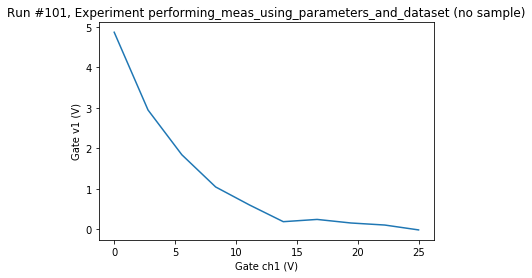

In [8]:
ax, cbax = plot_dataset(dataset)

### Exporting data

QCoDeS ``DataSet`` implements a number of methods for accessing the data of a given dataset. Here we will concentrate on the two most user friendly methods. For a more detailed walkthrough of the `DataSet` class, refer to [DataSet class walkthrough](DataSet-class-walkthrough.ipynb) notebook.

The method `get_parameter_data` returns the data as a dictionary of ``numpy`` arrays. The dictionary is indexed by the measured (dependent) parameter in the outermost level and the names of the dependent and independent parameters in the innermost level. The first parameter in the innermost level is always the dependent parameter.

In [9]:
datasaver.dataset.get_parameter_data()

{'dmm_v1': {'dmm_v1': array([ 4.86435026,  2.9436698 ,  1.83834811,  1.04277641,  0.59821309,
          0.18536189,  0.24111305,  0.15301598,  0.10254394, -0.01799718]),
  'dac_ch1': array([ 0.        ,  2.77777778,  5.55555556,  8.33333333, 11.11111111,
         13.88888889, 16.66666667, 19.44444444, 22.22222222, 25.        ])}}

By default `get_parameter_data` returns all data stored in the dataset. The data that is specific to one or more measured parameters can be returned by passing the parameter name(s) or by using `ParamSpec` object:

In [10]:
datasaver.dataset.get_parameter_data('dmm_v1')

{'dmm_v1': {'dmm_v1': array([ 4.86435026,  2.9436698 ,  1.83834811,  1.04277641,  0.59821309,
          0.18536189,  0.24111305,  0.15301598,  0.10254394, -0.01799718]),
  'dac_ch1': array([ 0.        ,  2.77777778,  5.55555556,  8.33333333, 11.11111111,
         13.88888889, 16.66666667, 19.44444444, 22.22222222, 25.        ])}}

You can also simply fetch the data for one or more dependent parameter

In [11]:
datasaver.dataset.get_parameter_data('dac_ch1')

{'dac_ch1': {'dac_ch1': array([ 0.        ,  2.77777778,  5.55555556,  8.33333333, 11.11111111,
         13.88888889, 16.66666667, 19.44444444, 22.22222222, 25.        ])}}

For more details about accessing data of a given `DataSet`, see [Accessing data in DataSet notebook](Accessing-data-in-DataSet.ipynb).

The data can also be exported as one or more [Pandas](https://pandas.pydata.org/) DataFrames. The DataFrames are returned as a dictionary from measured parameters to DataFrames.

In [12]:
datasaver.dataset.get_data_as_pandas_dataframe()['dmm_v1']

,dmm_v1
dac_ch1,
0.000000,4.864350
2.777778,2.943670
5.555556,1.838348
8.333333,1.042776
11.111111,0.598213
13.888889,0.185362
16.666667,0.241113
19.444444,0.153016
22.222222,0.102544


For more details about using Pandas and XArray see [Working With Pandas and XArray](./Working-With-Pandas-and-XArray.ipynb)

## Reloading datasets

To load existing datasets QCoDeS provides several functions. The most useful and generic function is called `load_by_run_spec`. 
This function takes one or more pieces of information about a dataset and will either, if the dataset is uniquely identifiable by the information, load the dataset or print information about all the datasets that match the supplied information allowing you to provide more information to uniquely identify the dataset.

Here, we will load a dataset based on the `captured_run_id` printed on the plot above.

In [13]:
datasaver.dataset.captured_run_id

101

In [14]:
loaded_ds = load_by_run_spec(captured_run_id=datasaver.dataset.captured_run_id)

In [15]:
loaded_ds.the_same_dataset_as(datasaver.dataset)

True

As long as you are working within one database file the dataset should be uniquely identified by `captured_run_id`. However, once you mix several datasets from different database files this is likely not unique. See the following section and [Extracting runs from one DB file to another](Extracting-runs-from-one-DB-file-to-another.ipynb) for more information on how to handle this.

### GUID

Internally each dataset is refereed too by a Globally Unique Identifier (GUID) that ensures that the dataset uniquely identified even if datasets from several databases with potentially identical captured_run_id, experiment and sample names.
A dataset can always be reloaded from the GUID if known. 

In [16]:
print(f"Dataset GUID is: {datasaver.dataset.guid}")

Dataset GUID is: aaaaaaaa-0000-0000-0000-0170f856844e


In [17]:
loaded_ds = load_by_guid(datasaver.dataset.guid)

In [18]:
loaded_ds.the_same_dataset_as(datasaver.dataset)

True

## The power of the new construct

This new form is so free that we may easily do thing impossible with the old Loop construct

In [19]:
# from the above plot, we decide that a voltage below 
# 1 V is uninteresting, so we stop the sweep at that point
# thus, we do not know in advance how many points we'll measure

with meas.run() as datasaver:
        
    for set_v in np.linspace(0, 25, 100):
        dac.ch1.set(set_v)
        get_v = dmm.v1.get()        
        datasaver.add_result((dac.ch1, set_v),
                             (dmm.v1, get_v))

        if get_v < 1:
            break
        
    
    dataset = datasaver.dataset  # convenient to have for plotting

Starting the measurement
Doing stuff with the following two instruments: <DummyInstrument: dmm>, <DummyInstrument: dac>
Starting experimental run with id: 102. 
End of experiment


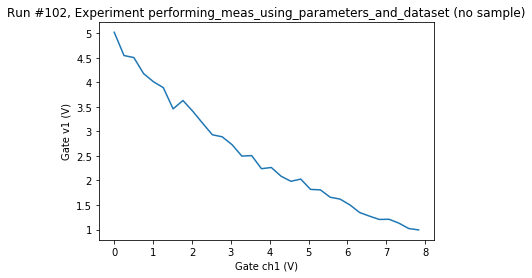

In [20]:
ax, cbax = plot_dataset(dataset)

In [21]:
# Or we might want to simply get as many points as possible in 10 s
# randomly sampling the region between 0 V and 10 V (for the setpoint axis)

from time import monotonic, sleep

with meas.run() as datasaver:
    
    t_start = monotonic()
    
    while monotonic() - t_start < 10:
        set_v = 10/2*(np.random.rand() + 1)
        dac.ch1.set(set_v)
        
        # some sleep to not get too many points (or to let the system settle)
        sleep(0.1)
        
        get_v = dmm.v1.get()        
        datasaver.add_result((dac.ch1, set_v),
                             (dmm.v1, get_v))
    
    dataset = datasaver.dataset  # convenient to have for plotting

Starting the measurement
Doing stuff with the following two instruments: <DummyInstrument: dmm>, <DummyInstrument: dac>
Starting experimental run with id: 103. 


End of experiment


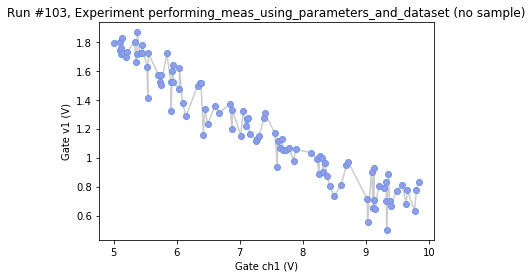

In [22]:
axes, cbax = plot_dataset(dataset)
# we slightly tweak the plot to better visualise the highly non-standard axis spacing
axes[0].lines[0].set_marker('o')
axes[0].lines[0].set_markerfacecolor((0.6, 0.6, 0.9))
axes[0].lines[0].set_markeredgecolor((0.4, 0.6, 0.9))
axes[0].lines[0].set_color((0.8, 0.8, 0.8))

## Some 2D examples

In [23]:
# For the 2D, we'll need a new batch of parameters, notably one with two 
# other parameters as setpoints. We therefore define a new Measurement
# with new parameters

meas = Measurement(exp=exp)
meas.register_parameter(dac.ch1)  # register the first independent parameter
meas.register_parameter(dac.ch2)  # register the second independent parameter
meas.register_parameter(dmm.v1, setpoints=(dac.ch1, dac.ch2))  # now register the dependent oone

In [24]:
# and we'll make a 2D gaussian to sample from/measure
def gauss_model(x0: float, y0: float, sigma: float, noise: float=0.0005):
    """
    Returns a generator sampling a gaussian. The gaussian is
    normalised such that its maximal value is simply 1
    """
    while True:
        (x, y) = yield
        model = np.exp(-((x0-x)**2+(y0-y)**2)/2/sigma**2)*np.exp(2*sigma**2)
        noise = np.random.randn()*noise
        yield model + noise

In [25]:
# and finally wire up the dmm v1 to "measure" the gaussian

gauss = gauss_model(0.1, 0.2, 0.25)
next(gauss)

def measure_gauss(dac):
    val = gauss.send((dac.ch1.get(), dac.ch2.get()))
    next(gauss)
    return val

dmm.v1.get = partial(measure_gauss, dac)

In [26]:
# run a 2D sweep

with meas.run() as datasaver:

    for v1 in np.linspace(-1, 1, 200):
        for v2 in np.linspace(-1, 1, 200):
            dac.ch1(v1)
            dac.ch2(v2)
            val = dmm.v1.get()
            datasaver.add_result((dac.ch1, v1),
                                 (dac.ch2, v2),
                                 (dmm.v1, val))
            
    dataset = datasaver.dataset  # convenient to have for plotting

Starting experimental run with id: 104. 


When exporting a two or higher dimensional datasets as a Pandas DataFrame a [MultiIndex](https://pandas.pydata.org/pandas-docs/stable/user_guide/advanced.html) is used to index the measured parameter based on all the dependencies

In [27]:
datasaver.dataset.get_data_as_pandas_dataframe()['dmm_v1'][0:10]

dmm_v1
dac_ch1 dac_ch2            
-1.0    -1.000000 -0.001269
        -0.989950 -0.000999
        -0.979899  0.000088
        -0.969849 -0.000067
        -0.959799  0.000044
        -0.949749  0.000037
        -0.939698  0.000015
        -0.929648 -0.000011
        -0.919598  0.000004
        -0.909548  0.000005

If your data is on a regular grid it may make sense to view the data as an [XArray](https://pandas.pydata.org/pandas-docs/stable/user_guide/advanced.html) Dataset. The Pandas DataFrame can be directly exported to a XArray Dataset.

In [28]:
datasaver.dataset.get_data_as_pandas_dataframe()['dmm_v1'].to_xarray()

<xarray.Dataset>
Dimensions:  (dac_ch1: 200, dac_ch2: 200)
Coordinates:
  * dac_ch1  (dac_ch1) float64 -1.0 -0.9899 -0.9799 ... 0.9799 0.9899 1.0
  * dac_ch2  (dac_ch2) float64 -1.0 -0.9899 -0.9799 ... 0.9799 0.9899 1.0
Data variables:
    dmm_v1   (dac_ch1, dac_ch2) float64 -0.001269 -0.0009987 ... 1.039e-05

Note, however, that XArray is only suited for data that is on a rectangular grid with few or no missing values. 

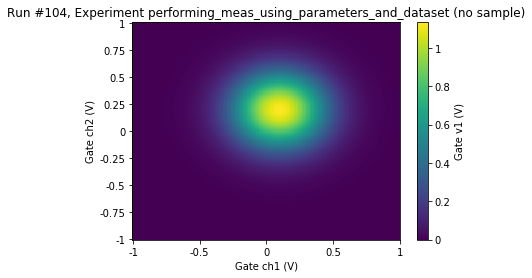

In [29]:
ax, cbax = plot_dataset(dataset)

In [30]:
# Looking at the above picture, we may decide to sample more finely in the central
# region

with meas.run() as datasaver:

    v1points = np.concatenate((np.linspace(-1, -0.5, 5),
                               np.linspace(-0.51, 0.5, 200),
                               np.linspace(0.51, 1, 5)))
    v2points = np.concatenate((np.linspace(-1, -0.25, 5),
                               np.linspace(-0.26, 0.5, 200),
                               np.linspace(0.51, 1, 5)))
    
    for v1 in v1points:
        for v2 in v2points:
            dac.ch1(v1)
            dac.ch2(v2)
            val = dmm.v1.get()
            datasaver.add_result((dac.ch1, v1),
                                 (dac.ch2, v2),
                                 (dmm.v1, val))

    dataset = datasaver.dataset  # convenient to have for plotting

Starting experimental run with id: 105. 


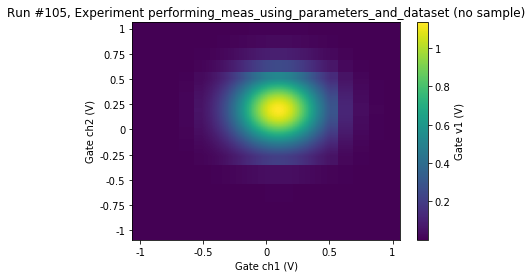

In [31]:
ax, cbax = plot_dataset(dataset)

In [32]:
# or even perform an adaptive sweep... ooohh...
#
# This example is a not-very-clever toy model example,
# but it nicely shows a semi-realistic measurement that the old qc.Loop
# could not handle

v1_points = np.linspace(-1, 1, 250)
v2_points = np.linspace(1, -1, 250)

threshold = 0.25

with meas.run() as datasaver:
    # Do normal sweeping until the peak is detected
    
    for v2ind, v2 in enumerate(v2_points):
        for v1ind, v1 in enumerate(v1_points):
            dac.ch1(v1)
            dac.ch2(v2)
            val = dmm.v1.get()
            datasaver.add_result((dac.ch1, v1),
                                 (dac.ch2, v2),
                                 (dmm.v1, val))
            if val > threshold:
                break
        else:
            continue
        break
        
    print(v1ind, v2ind, val)
    print('-'*10)
        
    # now be more clever, meandering back and forth over the peak
    doneyet = False
    rowdone = False
    v1_step = 1
    while not doneyet:
            v2 = v2_points[v2ind]
            v1 = v1_points[v1ind+v1_step-1]
            dac.ch1(v1)
            dac.ch2(v2)
            val = dmm.v1.get()
            datasaver.add_result((dac.ch1, v1),
                                 (dac.ch2, v2),
                                 (dmm.v1, val))
            if val < threshold:
                if rowdone:
                    doneyet = True
                v2ind += 1
                v1_step *= -1
                rowdone = True
            else:
                v1ind += v1_step
                rowdone = False
                
dataset = datasaver.dataset  # convenient to have for plotting

Starting experimental run with id: 106. 


130 46 0.2508941683095357
----------


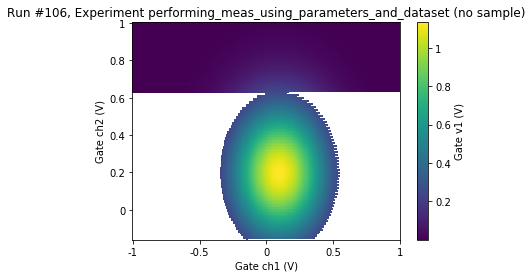

In [33]:
ax, cbax = plot_dataset(dataset)

## Interrupting measurments early

There may be cases where you do not want to complete a measurement. Currently QCoDeS is designed to allow the user
to interrupt the measurements with a standard KeyBoardInterrupt. KeyBoardInterrupts can be raised with either a Ctrl-C keyboard shortcut or using the interrupt button in Juypter / Spyder which is typically in the form of a Square stop button. QCoDeS is designed such that KeyboardInterrupts are delayed around critical parts of the code and the measurement is stopped when its safe to do so. 

## Random sampling 

We may also chose to sample completely randomly across the phase space

In [34]:
gauss = gauss_model(0.1, 0.2, 0.25)
next(gauss)

def measure_gauss(x, y):
    val = gauss.send((x, y))
    next(gauss)
    return val



In [35]:
v1_points = np.linspace(-1, 1, 250)
v2_points = np.linspace(1, -1, 250)

threshold = 0.25

npoints = 5000

with meas.run() as datasaver:
    for i in range(npoints):
        x = 2*(np.random.rand()-.5)
        y = 2*(np.random.rand()-.5)
        z = measure_gauss(x,y)
        datasaver.add_result((dac.ch1, x),
                     (dac.ch2, y),
                     (dmm.v1, z))
dataset = datasaver.dataset  # convenient to have for plotting

Starting experimental run with id: 107. 


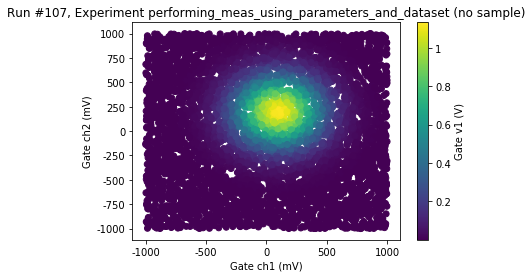

In [36]:
ax, cbax = plot_dataset(dataset)

In [37]:
datasaver.dataset.get_data_as_pandas_dataframe()['dmm_v1'][0:10]

,,dmm_v1
dac_ch1,dac_ch2,
0.508140,0.175038,0.297353
0.802560,-0.266218,0.003896
0.870747,0.041015,0.007944
0.221784,0.629622,0.229728
-0.008920,0.383994,0.785929
-0.221336,0.875964,0.012874
-0.727751,-0.306233,0.000634
0.578724,-0.538335,0.002260
-0.496646,0.181571,0.065481


Unlike the data measured above, which lies on a grid, here, all the measured data points have an unique combination of the two dependent parameters. When exporting to XArray NaN's will therefore replace all the missing combinations of `dac_ch1` and `dac_ch2` and the data is unlikely to be useful in this format. 

In [38]:
#df_sliced = datasaver.dataset.get_data_as_pandas_dataframe()['dmm_v1'].sort_index()[0:10]
#df_sliced.index = df_sliced.index.remove_unused_levels()
#df_sliced.to_xarray()

## Optimiser

An example to show that the algorithm is flexible enough to be used with completely unstructured data such as the output of an downhill simplex optimization. The downhill simplex is somewhat more sensitive to noise and it is important that 'fatol' is set to match the expected noise.

In [39]:
from scipy.optimize import minimize

In [40]:
noise = 0.0005

gauss = gauss_model(0.1, 0.2, 0.25, noise=noise)
next(gauss)

def measure_gauss(x, y):
    val = gauss.send((x, y))
    next(gauss)
    return val


In [41]:
x0 = [np.random.rand(), np.random.rand()]
with meas.run() as datasaver:
    def mycallback(xk):
        datasaver.add_result((dac.ch1, xk[0]),
                     (dac.ch2, xk[1]),
                     (dmm.v1, measure_gauss(xk[0], xk[1])))
    
    res = minimize(lambda x: -measure_gauss(*x), x0, method='Nelder-Mead', tol=1e-10, 
                   callback=mycallback, options={'fatol': noise})
    
    dataset = datasaver.dataset  # convenient to have for plotting

Starting experimental run with id: 108. 


In [42]:
res

 final_simplex: (array([[0.1, 0.2],
       [0.1, 0.2],
       [0.1, 0.2]]), array([-1.13314845, -1.13314845, -1.13314845]))
           fun: -1.1331484530668263
       message: 'Optimization terminated successfully.'
          nfev: 146
           nit: 72
        status: 0
       success: True
             x: array([0.1, 0.2])

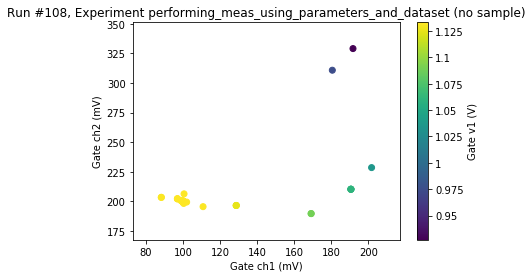

In [43]:
ax, cbax = plot_dataset(dataset)

## Subscriptions

The ``Measurement`` object can also handle subscriptions to the dataset. Subscriptions are, under the hood, triggers in the underlying SQLite database. Therefore, the subscribers are only called when data is written to the database (which happens every `write_period`).

When making a subscription, two things must be supplied: a function and a mutable state object. The function **MUST** have a call signature of `f(result_list, length, state, **kwargs)`, where ``result_list`` is a list of tuples of parameter values inserted in the dataset, ``length`` is an integer (the step number of the run), and ``state`` is the mutable state object. The function does not need to actually use these arguments, but the call signature must match this.

Let us consider two generic examples:

### Subscription example 1: simple printing

In [44]:


def print_which_step(results_list, length, state):
    """
    This subscriber does not use results_list nor state; it simply
    prints how many results we have added to the database
    """
    print(f'The run now holds {length} rows')
    
    
meas = Measurement(exp=exp)
meas.register_parameter(dac.ch1)
meas.register_parameter(dmm.v1, setpoints=(dac.ch1,))

meas.write_period = 1  # We write to the database every 1 second

meas.add_subscriber(print_which_step, state=[])

with meas.run() as datasaver:
    for n in range(10):
        datasaver.add_result((dac.ch1, n), (dmm.v1, n**2))
        print(f'Added points to measurement, step {n}.')
        sleep(0.5)

Starting experimental run with id: 109. 
Added points to measurement, step 0.


Added points to measurement, step 1.


The run now holds 3 rows
Added points to measurement, step 2.


Added points to measurement, step 3.


The run now holds 5 rows
Added points to measurement, step 4.


Added points to measurement, step 5.


The run now holds 7 rows
Added points to measurement, step 6.


Added points to measurement, step 7.


The run now holds 9 rows
Added points to measurement, step 8.


Added points to measurement, step 9.


The run now holds 10 rows
The run now holds 10 rows
The run now holds 10 rows


### Subscription example 2: using the state

We add two subscribers now.

In [45]:


def get_list_of_first_param(results_list, lenght, state):
    """
    Modify the state (a list) to hold all the values for
    the first parameter
    """
    param_vals = [parvals[0] for parvals in results_list]
    state += param_vals
    
meas = Measurement(exp=exp)
meas.register_parameter(dac.ch1)
meas.register_parameter(dmm.v1, setpoints=(dac.ch1,))

meas.write_period = 1  # We write to the database every 1 second

first_param_list = []

meas.add_subscriber(print_which_step, state=[])
meas.add_subscriber(get_list_of_first_param, state=first_param_list)

with meas.run() as datasaver:
    for n in range(10):
        datasaver.add_result((dac.ch1, n), (dmm.v1, n**2))
        print(f'Added points to measurement, step {n}.')
        print(f'First parameter value list: {first_param_list}')
        sleep(0.5)

Starting experimental run with id: 110. 
Added points to measurement, step 0.
First parameter value list: []


Added points to measurement, step 1.
First parameter value list: []


The run now holds 3 rows
Added points to measurement, step 2.
First parameter value list: [0, 1, 2]


Added points to measurement, step 3.
First parameter value list: [0, 1, 2]


The run now holds 5 rows
Added points to measurement, step 4.
First parameter value list: [0, 1, 2, 3, 4]


Added points to measurement, step 5.
First parameter value list: [0, 1, 2, 3, 4]


The run now holds 7 rows
Added points to measurement, step 6.
First parameter value list: [0, 1, 2, 3, 4, 5, 6]


Added points to measurement, step 7.
First parameter value list: [0, 1, 2, 3, 4, 5, 6]


Added points to measurement, step 8.
First parameter value list: [0, 1, 2, 3, 4, 5, 6, 7, 8]
The run now holds 9 rows


Added points to measurement, step 9.
First parameter value list: [0, 1, 2, 3, 4, 5, 6, 7, 8]


The run now holds 10 rows
The run now holds 10 rows
The run now holds 10 rows


## QCoDeS Array and MultiParameter

The ``Measurement`` object supports automatic handling of ``Array`` and ``MultiParameters``. When registering these parameters 
the individual components are unpacked and added to the dataset as if they were separate parameters. Lets consider a ``MultiParamter`` with array components as the most general case.

First lets use a dummy instrument that produces data as ``Array`` and ``MultiParameters``.

In [46]:
from qcodes.tests.instrument_mocks import DummyChannelInstrument

In [47]:
mydummy = DummyChannelInstrument('MyDummy')

This instrument produces two ``Array``s with the names, shapes and setpoints given below.

In [48]:
mydummy.A.dummy_2d_multi_parameter.names

('this', 'that')

In [49]:
mydummy.A.dummy_2d_multi_parameter.shapes

((5, 3), (5, 3))

In [50]:
mydummy.A.dummy_2d_multi_parameter.setpoint_names

(('this_setpoint', 'that_setpoint'), ('this_setpoint', 'that_setpoint'))

In [51]:
meas = Measurement(exp=exp)

meas.register_parameter(mydummy.A.dummy_2d_multi_parameter)
meas.parameters

{'this': ParamSpecBase('this', 'numeric', 'this label', 'this unit'),
 'MyDummy_ChanA_this_setpoint': ParamSpecBase('MyDummy_ChanA_this_setpoint', 'numeric', 'this setpoint', 'this setpointunit'),
 'MyDummy_ChanA_that_setpoint': ParamSpecBase('MyDummy_ChanA_that_setpoint', 'numeric', 'that setpoint', 'that setpointunit'),
 'that': ParamSpecBase('that', 'numeric', 'that label', 'that unit')}

When adding the MultiParameter to the measurement we can see that we add each of the individual components as a 
separate parameter.

In [52]:
with meas.run() as datasaver:
    datasaver.add_result((mydummy.A.dummy_2d_multi_parameter, mydummy.A.dummy_2d_multi_parameter()))

Starting experimental run with id: 111. 


And when adding the result of a ``MultiParameter`` it is automatically unpacked into its components.

([<matplotlib.axes._subplots.AxesSubplot at 0x7f1a300fde10>,
  <matplotlib.colorbar.Colorbar at 0x7f1a33934490>])

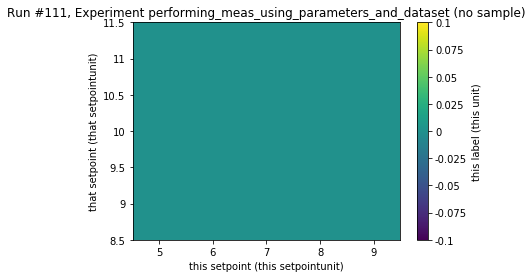

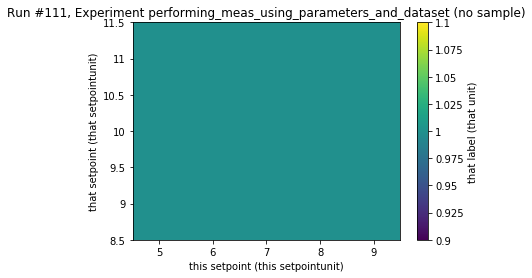

In [53]:
plot_dataset(datasaver.dataset)

In [54]:
datasaver.dataset.get_parameter_data('that')

{'that': {'that': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]),
  'MyDummy_ChanA_this_setpoint': array([5, 5, 5, 6, 6, 6, 7, 7, 7, 8, 8, 8, 9, 9, 9]),
  'MyDummy_ChanA_that_setpoint': array([ 9, 10, 11,  9, 10, 11,  9, 10, 11,  9, 10, 11,  9, 10, 11])}}

In [55]:
datasaver.dataset.get_data_as_pandas_dataframe()['that']

that
MyDummy_ChanA_this_setpoint MyDummy_ChanA_that_setpoint      
5                           9                               1
                            10                              1
                            11                              1
6                           9                               1
                            10                              1
                            11                              1
7                           9                               1
                            10                              1
                            11                              1
8                           9                               1
                            10                              1
                            11                              1
9                           9                               1
                            10                              1
                            11                              1

In [56]:
datasaver.dataset.get_data_as_pandas_dataframe()['that'].to_xarray()

<xarray.Dataset>
Dimensions:                      (MyDummy_ChanA_that_setpoint: 3, MyDummy_ChanA_this_setpoint: 5)
Coordinates:
  * MyDummy_ChanA_this_setpoint  (MyDummy_ChanA_this_setpoint) int64 5 6 7 8 9
  * MyDummy_ChanA_that_setpoint  (MyDummy_ChanA_that_setpoint) int64 9 10 11
Data variables:
    that                         (MyDummy_ChanA_this_setpoint, MyDummy_ChanA_that_setpoint) int64 1 ... 1